In [7]:
import pandas as pd
import plotly.express as px
import re
import nltk
from nltk.corpus import stopwords
import ollama
import sys # Necesario para sys.stdout.flush() y \r

In [8]:
pd.set_option('display.max_columns', None)

# Carga de data

In [9]:
df = pd.read_excel(r"C:\Users\sgcontrolgest\OneDrive - Mutual\Text Mining\Glosa ME2L\ME2L Acum 2025.XLSX", sheet_name= 'Sheet1')

## Filtro clínicas y hospitales

In [10]:
mapeo_cuentas = {
    # "Acciones de PRP": 510811,
    # "Aplicaciones": 511700,
    # "Aporte Mutual": 511509,
    # "Aportes Previsionales s/Subsi": 510001,
    # "Asesorías y Consultorias": 511602,
    # "Asignaciones Imponib.Variables": 511503,
    # "Asignaciones Imponibles Fijas": 511502,
    # "Aumento.Capit.Repre Tramite": 512405,
    # "Bonos": 511506,
    "Clínicas y Hospitales": 510601,
    # "Constitución Capitales Repres. Vigente": 512400,
    # "Estim Incob Prov. No facturada": 530754,
    # "Fármacos..": 510700,
    # "Gastos Medicos de Filiales": 510610,
    # "Gratificaciones": 511505,
    # "Honorarios Apoyo Clínico": 510606,
    # "Honorarios Médicos": 510604,
    # "Honorarios PRP especiales": 510801,
    # "Horas Extraordinarias": 511508,
    # "Implantes AO..": 510702,
    # "Indemnización Años de Servici": 511511,
    # "Indemnizaciones": 510100,
    # "Insumos Clínicos..": 510701,
    # "Pensiones": 510200,
    # "Plataforma": 511702,
    # "Servicios de Continuidad Operacional": 511523,
    # "Servicios Externos Administrativos": 511601,
    # "Subsidios": 510000,
    # "Sueldos Base": 511500,
    # "Traslado accidentado": 510608,
    # "Vacaciones Consumidas": 511516,
    # "Vacaciones Devengadas": 511515
}


In [11]:
df['Cuenta de mayor'] = df['Cuenta de mayor'].fillna(0).astype(int)
df['Cuenta de mayor'].value_counts()

Cuenta de mayor
510604    26254
510602    24906
510601    18087
510606    16343
510608    15541
          ...  
112715        2
511402        2
113900        1
512318        1
511320        1
Name: count, Length: 139, dtype: int64

In [12]:
df['nombre_cuenta'] = df['Cuenta de mayor'].map({v: k for k, v in mapeo_cuentas.items()})
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195679 entries, 0 to 195678
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Unnamed: 0              195679 non-null  int64         
 1   Documento compras       195679 non-null  int64         
 2   Grupo de compras        195679 non-null  object        
 3   Grupo de liberación     185692 non-null  object        
 4   Posición                195679 non-null  int64         
 5   Fecha documento         195679 non-null  datetime64[ns]
 6   Nombre del proveedor    195674 non-null  object        
 7   Material                90317 non-null   object        
 8   Texto breve             195557 non-null  object        
 9   Cantidad de pedido      195679 non-null  float64       
 10  Cantidad en UMA         195679 non-null  float64       
 11  Cantidad de imputación  195679 non-null  float64       
 12  Unidad medida pedido    195669

,Unnamed: 0,Documento compras,Grupo de compras,Grupo de liberación,Posición,Fecha documento,Nombre del proveedor,Material,Texto breve,Cantidad de pedido,Cantidad en UMA,Cantidad de imputación,Unidad medida pedido,Precio neto,Moneda,Centro,Ind.liberación,Centro de coste,Cuenta de mayor,Orden,Indicador de borrado,Indicador de borrado.1,Estado liberación,Cantidad base,Cl.documento compras,Unnamed: 25,nombre_cuenta
0,4500071273,4500071273,S03,NaN,10,2024-11-18,761235001 COMERCIAL BRUNO KEVRIC Y,NaN,REPARACION CAMIONETA GBTV74,1.0,0.0,1.0,UN,89250.0,CLP,1200.0,NaN,20351,511205,NaN,NaN,L,NaN,1,NB,NaN,NaN
1,4500071385,4500071385,G22,NaN,10,2024-11-25,920110002 EMPRESA NACIONAL DE ENER,118100044,"COMBUSTIBLE DIESEL, FACTURA",1.0,1.0,1.0,UN,37305.0,CLP,1100.0,NaN,596245,512300,NaN,NaN,L,NaN,1,NB,NaN,NaN
2,4500071459,4500071459,S14,NaN,10,2024-11-29,162390422 EDUARDO ALEXIS LOPEZ LEO,115800098,HONORARIO MEDICO CIRUGÍA,1.0,1.0,1.0,UN,1.0,CLP,2300.0,NaN,90122,510606,200508100920,NaN,L,NaN,1,NB,NaN,NaN
3,4500071583,4500071583,S16,NaN,10,2024-12-11,819491003 CORPORACION DE BENEFICEN,NaN,CBO;CONTROL;L.FERNANDEZ;11028,1.0,0.0,1.0,UN,62819.0,CLP,2500.0,NaN,101122,510604,202409172636,NaN,NaN,NaN,1,NB,NaN,NaN
4,4500071583,4500071583,S16,NaN,20,2024-12-11,819491003 CORPORACION DE BENEFICEN,NaN,CBO;CONTROL;A.PEREZ;8678,1.0,0.0,1.0,UN,62819.0,CLP,2500.0,NaN,NaN,510604,101122,NaN,NaN,NaN,1,NB,NaN,NaN


In [13]:
df_cl = df[df['nombre_cuenta'].notna()]
df_cl.info()
df_cl.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18087 entries, 30801 to 195644
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              18087 non-null  int64         
 1   Documento compras       18087 non-null  int64         
 2   Grupo de compras        18087 non-null  object        
 3   Grupo de liberación     16711 non-null  object        
 4   Posición                18087 non-null  int64         
 5   Fecha documento         18087 non-null  datetime64[ns]
 6   Nombre del proveedor    18087 non-null  object        
 7   Material                16798 non-null  object        
 8   Texto breve             18086 non-null  object        
 9   Cantidad de pedido      18087 non-null  float64       
 10  Cantidad en UMA         18087 non-null  float64       
 11  Cantidad de imputación  18087 non-null  float64       
 12  Unidad medida pedido    18087 non-null  object

,Unnamed: 0,Documento compras,Grupo de compras,Grupo de liberación,Posición,Fecha documento,Nombre del proveedor,Material,Texto breve,Cantidad de pedido,Cantidad en UMA,Cantidad de imputación,Unidad medida pedido,Precio neto,Moneda,Centro,Ind.liberación,Centro de coste,Cuenta de mayor,Orden,Indicador de borrado,Indicador de borrado.1,Estado liberación,Cantidad base,Cl.documento compras,Unnamed: 25,nombre_cuenta
30801,4561463896,4561463896,S08,P3,10,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,33110.0,CLP,1700.0,2.0,61121,510601,202409180966,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales
30802,4561463896,4561463896,S08,P3,20,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,54790.0,CLP,1700.0,2.0,61121,510601,202409190828,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales
30803,4561463896,4561463896,S08,P3,30,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,17210.0,CLP,1700.0,2.0,61121,510601,202409190231,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales
30876,4561463932,4561463932,S13,P3,10,2024-11-04,116996766 GLORIA LUZ SILVA OSSES,NaN,Hon. Arsenalera- Juan Mondaca,1.0,0.0,1.0,UN,35000.0,CLP,2200.0,2.0,82132,510601,202409132786,NaN,NaN,X,1,PSPF,NaN,Clínicas y Hospitales
31003,4561463961,4561463961,S17,P3,10,2024-11-04,762619059 CENTRO MEDICO LOS ANDES,115800115,CMUPM;HOSP;EVELYN PRISCILA VARGAS TORRES,1.0,1.0,1.0,UN,425030.0,CLP,2600.0,2.0,106131,510601,202308847774,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales


# Procesamiento

In [9]:
# --- Definición del Prompt de Sistema ---
# Este prompt instruye al modelo sobre su rol y las categorías esperadas.
system_prompt = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Tu tarea es analizar el texto de la glosa proporcionado por el usuario y clasificarlo en UNA de las siguientes categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Considera el contexto completo del texto para realizar la clasificación. Responde únicamente con el nombre de la categoría seleccionada de la lista anterior, sin añadir explicaciones, introducciones o texto adicional.
"""


In [10]:

# # --- Función para Clasificar un Texto Individual ---
# def clasificar_glosa_con_phi4(texto_glosa):
#     """
#     Envía un texto de glosa a Ollama (phi4) para su clasificación.

#     Args:
#         texto_glosa (str): El texto de la glosa a clasificar.

#     Returns:
#         str: La categoría predicha por el modelo o 'Error en clasificación' si falla.
#     """
#     if not texto_glosa or not isinstance(texto_glosa, str) or texto_glosa.strip() == "":
#          return "Texto inválido" # Opcional: manejar textos vacíos o no válidos

#     messages = [
#         {'role': 'system', 'content': system_prompt},
#         {'role': 'user', 'content': texto_glosa}
#     ]
#     try:
#         response = ollama.chat(model='phi4', messages=messages)
#         # Extraer la clasificación directamente del contenido del mensaje
#         clasificacion = response['message']['content'].strip()

#         # Verificación simple (opcional pero recomendado): Chequear si la respuesta es una de las categorías válidas
#         categorias_validas = [
#             'Atención de urgencia', 'Hospitalización', 'Diagnóstico / imagenología',
#             'Procedimientos quirúrgicos', 'Medicamentos e insumos',
#             'Profesionales y honorarios', 'Ley de pacientes'
#         ]
#         if clasificacion in categorias_validas:
#              return clasificacion
#         else:
#              # A veces el modelo puede añadir texto extra. Intentar encontrar la categoría.
#              # Esto es un manejo básico, podría necesitar refinamiento.
#              for cat in categorias_validas:
#                  if cat.lower() in clasificacion.lower():
#                      print(f"Advertencia: Respuesta no exacta '{clasificacion}', pero se encontró categoría '{cat}' para texto: '{texto_glosa}'")
#                      return cat
#              print(f"Advertencia: Respuesta inesperada del modelo: '{clasificacion}' para texto: '{texto_glosa}'")
#              return "Clasificación ambigua" # O asignar una categoría por defecto o revisar manualmente

#     except Exception as e:
#         print(f"Error al procesar el texto '{texto_glosa}': {e}")
#         return "Error en clasificación"

In [11]:

# # --- Procesamiento Iterativo del DataFrame ---
# # Aplicar la función a cada fila de la columna 'Texto breve'
# # Se crea una nueva columna 'Clasificacion_Phi4' con los resultados.
# print("Iniciando clasificación de glosas...")
# df_cl['Clasificacion_Phi4'] = df_cl['Texto breve'].apply(clasificar_glosa_con_phi4)
# print("Clasificación completada.")

# # --- Mostrar Resultados ---
# print("\nDataFrame con clasificaciones:")
# print(df_cl)

# # --- Opcional: Guardar el DataFrame resultante ---
# # df_cl.to_excel("glosas_clasificadas.xlsx", index=False)
# # df_cl.to_csv("glosas_clasificadas.csv", index=False)

Iniciando clasificación de glosas...
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero se encontró categoría 'Atención de urgencia' para texto: 'ATENCION DE URGENCIA'
Advertencia: Respuesta no exacta 'Atención de urgencia
[/end]', pero 

KeyboardInterrupt: 

---

In [ ]:
# --- Definición del Prompt de Sistema ---
# Mantenemos el mismo prompt efectivo
system_prompt = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Tu tarea es analizar el texto de la glosa proporcionado por el usuario y clasificarlo en UNA de las siguientes categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Considera el contexto completo del texto para realizar la clasificación. Responde únicamente con el nombre de la categoría seleccionada de la lista anterior, sin añadir explicaciones, introducciones o texto adicional. Si el texto no corresponde claramente a ninguna de estas categorías, responde 'Sin clasificar'.
"""


In [12]:

# Lista de categorías válidas para verificación
categorias_validas = [
    'Atención de urgencia', 'Hospitalización', 'Diagnóstico / imagenología',
    'Procedimientos quirúrgicos', 'Medicamentos e insumos',
    'Profesionales y honorarios', 'Ley de pacientes'
]

# --- Función para Clasificar un Texto Individual (modificada) ---
def clasificar_glosa_con_phi4(texto_glosa):
    """
    Envía un texto de glosa a Ollama (phi4) para su clasificación.

    Args:
        texto_glosa (str): El texto de la glosa a clasificar.

    Returns:
        str: La categoría predicha por el modelo o 'Sin clasificar'.
    """
    # Manejar textos vacíos, None o no-string antes de llamar a la API
    if not texto_glosa or not isinstance(texto_glosa, str) or texto_glosa.strip() == "":
         return "Sin clasificar"

    messages = [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': texto_glosa}
    ]
    try:
        response = ollama.chat(model='phi4', messages=messages)
        clasificacion = response['message']['content'].strip()

        # Permitir la respuesta directa 'Sin clasificar' del modelo
        if clasificacion == 'Sin clasificar':
            return clasificacion

        # Chequear si la respuesta es una de las categorías válidas
        if clasificacion in categorias_validas:
             return clasificacion
        else:
             # Intentar encontrar una categoría válida si el modelo añadió texto extra
             for cat in categorias_validas:
                 # Búsqueda más estricta para evitar falsos positivos
                 # Por ejemplo, si responde "La categoría es: Hospitalización"
                 if cat.lower() in clasificacion.lower():
                     # Podríamos añadir una advertencia aquí si quisiéramos
                     # print(f"Advertencia: Respuesta no exacta '{clasificacion}', pero se encontró categoría '{cat}'...")
                     return cat
             # Si después de intentar encontrarla, no coincide, marcar como Sin clasificar
             return "Sin clasificar"

    except Exception as e:
        # Imprimir el error específico puede ser útil para depurar
        print(f"\nError en API Ollama para texto '{texto_glosa}': {e}")
        return "Sin clasificar" # Devolver 'Sin clasificar' en caso de error


In [16]:
# --- Procesamiento Iterativo del DataFrame con Progreso ---
print("Iniciando clasificación de glosas...")
total_rows = len(df_cl)
results = [] # Lista para guardar los resultados

for index, row in df_cl.iterrows():
    texto_actual = row['Texto breve']

    # Llamar a la función de clasificación
    clasificacion_actual = clasificar_glosa_con_phi4(texto_actual)

    # Guardar el resultado
    results.append(clasificacion_actual)

    # Calcular progreso
    current_row_num = index + 1
    percentage = (current_row_num / total_rows) * 100

    # Limitar longitud del texto para impresión limpia
    texto_corto = str(texto_actual)[:60] + '...' if isinstance(texto_actual, str) and len(texto_actual) > 60 else str(texto_actual)

    # Imprimir progreso (sobrescribe la línea anterior) y detalle
    # Usamos \r para volver al inicio de la línea. end='' evita el salto de línea.
    # sys.stdout.flush() asegura que se imprima inmediatamente.
    print(f"\rProcesando fila {current_row_num}/{total_rows} ({percentage:.1f}%) - Texto: '{texto_corto}' -> Clasificado como: '{clasificacion_actual}'", end='')
    sys.stdout.flush()

    # Opcional: Si quieres un log persistente (no sobrescrito), usa:
    # print(f"Fila {current_row_num}/{total_rows} ({percentage:.1f}%): Texto '{texto_corto}' -> Clasificado como '{clasificacion_actual}'")

# Imprimir una nueva línea al final para limpiar la línea de progreso
print("\nClasificación completada.")

# Añadir la lista de resultados como nueva columna al DataFrame
df_cl['Clasificacion_Phi4'] = results

# --- Mostrar Resultados Finales ---
print("\nDataFrame con clasificaciones:")
print(df_cl)


Iniciando clasificación de glosas...
Procesando fila 30803/18087 (170.3%) - Texto: 'ATENCION DE URGENCIA' -> Clasificado como: 'Atención de urgencia'

KeyboardInterrupt: 

---

In [17]:
# --- Definición del Prompt de Sistema (sin cambios) ---
system_prompt = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Tu tarea es analizar el texto de la glosa proporcionado por el usuario y clasificarlo en UNA de las siguientes categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Considera el contexto completo del texto para realizar la clasificación. Responde únicamente con el nombre de la categoría seleccionada de la lista anterior, sin añadir explicaciones, introducciones o texto adicional. Si el texto no corresponde claramente a ninguna de estas categorías, responde 'Sin clasificar'.
"""

categorias_validas = [
    'Atención de urgencia', 'Hospitalización', 'Diagnóstico / imagenología',
    'Procedimientos quirúrgicos', 'Medicamentos e insumos',
    'Profesionales y honorarios', 'Ley de pacientes'
]

# --- Función para Clasificar un Texto Individual (sin cambios) ---
def clasificar_glosa_con_phi4(texto_glosa):
    if not texto_glosa or not isinstance(texto_glosa, str) or texto_glosa.strip() == "":
         return "Sin clasificar"
    messages = [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': texto_glosa}
    ]
    try:
        response = ollama.chat(model='phi4', messages=messages)
        clasificacion = response['message']['content'].strip()
        if clasificacion == 'Sin clasificar':
            return clasificacion
        if clasificacion in categorias_validas:
             return clasificacion
        else:
             for cat in categorias_validas:
                 if cat.lower() in clasificacion.lower():
                     return cat
             return "Sin clasificar"
    except Exception as e:
        print(f"\nError en API Ollama para texto '{texto_glosa}': {e}")
        return "Sin clasificar"

# --- Procesamiento Iterativo del DataFrame con Progreso (CORREGIDO) ---
total_rows = len(df_cl)
print(f"Iniciando clasificación de {total_rows} glosas...")
results = []

# Usar enumerate para obtener un contador secuencial (i) además del índice real (index)
for i, (index, row) in enumerate(df_cl.iterrows()):
    # 'i' será 0 para la primera fila, 1 para la segunda, etc.
    # 'index' seguirá siendo la etiqueta real del índice (ej. 30802, 30805...)
    # 'row' contiene los datos de la fila

    texto_actual = row['Texto breve']
    clasificacion_actual = clasificar_glosa_con_phi4(texto_actual)
    results.append(clasificacion_actual)

    # Calcular progreso USANDO EL CONTADOR SECUENCIAL 'i'
    current_row_num = i + 1 # Esto ahora será 1, 2, 3,... correctamente
    percentage = (current_row_num / total_rows) * 100

    texto_corto = str(texto_actual)[:60] + '...' if isinstance(texto_actual, str) and len(texto_actual) > 60 else str(texto_actual)

    # Imprimir progreso (usa current_row_num que ahora es correcto)
    print(f"\rProcesando fila {current_row_num}/{total_rows} ({percentage:.1f}%) - Texto: '{texto_corto}' -> Clasificado como: '{clasificacion_actual}'", end='')
    sys.stdout.flush()

print("\nClasificación completada.")

df_cl['Clasificacion_Phi4'] = results

# --- Mostrar Resultados Finales ---
print("\nDataFrame con clasificaciones:")
# Mostramos también el índice para ver que no es secuencial
print(df_cl)

# --- Opcional: Guardar el DataFrame resultante ---
# df_cl.to_excel("glosas_clasificadas_v3.xlsx", index=True) # Guardar con índice si es relevante
# df_cl.to_csv("glosas_clasificadas_v3.csv", index=True)

Iniciando clasificación de 18087 glosas...
Procesando fila 18087/18087 (100.0%) - Texto: 'HN ARSENALERA JORGE GUTIERREZ 18189381-8' -> Clasificado como: 'Profesionales y honorarios'
Clasificación completada.

DataFrame con clasificaciones:
        Unnamed: 0  Documento compras Grupo de compras Grupo de liberación  \
30801   4561463896         4561463896              S08                  P3   
30802   4561463896         4561463896              S08                  P3   
30803   4561463896         4561463896              S08                  P3   
30876   4561463932         4561463932              S13                  P3   
31003   4561463961         4561463961              S17                  P3   
...            ...                ...              ...                 ...   
195640  4561495237         4561495237              S12                  P3   
195641  4561495237         4561495237              S12                  P3   
195642  4561495237         4561495237              S12    

C:\Users\sgcontrolgest\AppData\Local\Temp\ipykernel_21388\1515567886.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['Clasificacion_Phi4'] = results


In [18]:
df_cl.info()
df_cl.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18087 entries, 30801 to 195644
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              18087 non-null  int64         
 1   Documento compras       18087 non-null  int64         
 2   Grupo de compras        18087 non-null  object        
 3   Grupo de liberación     16711 non-null  object        
 4   Posición                18087 non-null  int64         
 5   Fecha documento         18087 non-null  datetime64[ns]
 6   Nombre del proveedor    18087 non-null  object        
 7   Material                16798 non-null  object        
 8   Texto breve             18086 non-null  object        
 9   Cantidad de pedido      18087 non-null  float64       
 10  Cantidad en UMA         18087 non-null  float64       
 11  Cantidad de imputación  18087 non-null  float64       
 12  Unidad medida pedido    18087 non-null  object

,Unnamed: 0,Documento compras,Grupo de compras,Grupo de liberación,Posición,Fecha documento,Nombre del proveedor,Material,Texto breve,Cantidad de pedido,Cantidad en UMA,Cantidad de imputación,Unidad medida pedido,Precio neto,Moneda,Centro,Ind.liberación,Centro de coste,Cuenta de mayor,Orden,Indicador de borrado,Indicador de borrado.1,Estado liberación,Cantidad base,Cl.documento compras,Unnamed: 25,nombre_cuenta,Clasificacion_Phi4
30801,4561463896,4561463896,S08,P3,10,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,33110.0,CLP,1700.0,2.0,61121,510601,202409180966,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales,Atención de urgencia
30802,4561463896,4561463896,S08,P3,20,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,54790.0,CLP,1700.0,2.0,61121,510601,202409190828,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales,Atención de urgencia
30803,4561463896,4561463896,S08,P3,30,2024-11-02,616021427 HOSPITAL DE PEUMO,115800002,ATENCION DE URGENCIA,1.0,1.0,1.0,UN,17210.0,CLP,1700.0,2.0,61121,510601,202409190231,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales,Atención de urgencia
30876,4561463932,4561463932,S13,P3,10,2024-11-04,116996766 GLORIA LUZ SILVA OSSES,NaN,Hon. Arsenalera- Juan Mondaca,1.0,0.0,1.0,UN,35000.0,CLP,2200.0,2.0,82132,510601,202409132786,NaN,NaN,X,1,PSPF,NaN,Clínicas y Hospitales,Ley de pacientes
31003,4561463961,4561463961,S17,P3,10,2024-11-04,762619059 CENTRO MEDICO LOS ANDES,115800115,CMUPM;HOSP;EVELYN PRISCILA VARGAS TORRES,1.0,1.0,1.0,UN,425030.0,CLP,2600.0,2.0,106131,510601,202308847774,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales,Hospitalización


In [19]:
df_cl.to_excel("glosas_clasificadas_me2l.xlsx", index=True) # Guardar con índice si es relevante

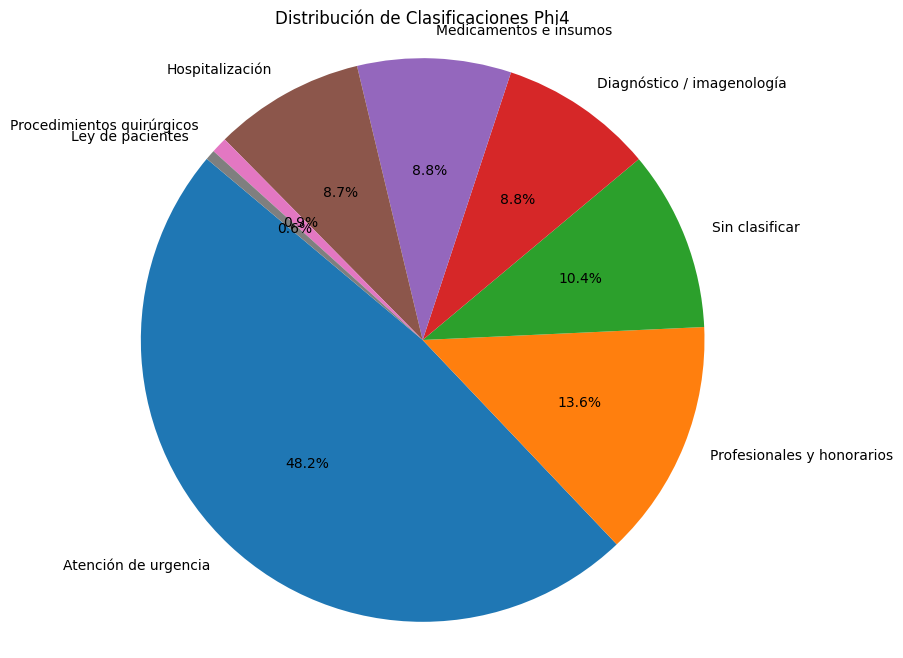

In [22]:
import matplotlib.pyplot as plt

# Obtener los conteos de cada clasificación
conteos = df_cl.Clasificacion_Phi4.value_counts()

# Crear un gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(conteos, labels=conteos.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Clasificaciones Phi4')
plt.axis('equal')  # Asegurar que el gráfico sea un círculo
plt.show()

In [23]:
df_cl[df_cl.Clasificacion_Phi4=='Sin clasificar']

,Unnamed: 0,Documento compras,Grupo de compras,Grupo de liberación,Posición,Fecha documento,Nombre del proveedor,Material,Texto breve,Cantidad de pedido,Cantidad en UMA,Cantidad de imputación,Unidad medida pedido,Precio neto,Moneda,Centro,Ind.liberación,Centro de coste,Cuenta de mayor,Orden,Indicador de borrado,Indicador de borrado.1,Estado liberación,Cantidad base,Cl.documento compras,Unnamed: 25,nombre_cuenta,Clasificacion_Phi4
32403,4561464166,4561464166,S13,P3,70,2024-11-04,827453005 CORP. IGLESIA DE LOS ADV,115800031,Arco C,1.0,1.0,1.0,UN,65000.0,CLP,2200.0,2.0,82132,510601,202409175588,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
36006,4561464652,4561464652,S12,P3,10,2024-11-05,765150701 CLINICA ANDES SALUD CHIL,115800004,RUT12967782-1 CRISTIAN SEPULVEDA DCA,1.0,1.0,1.0,UN,314246.0,CLP,2100.0,2.0,81131,510601,202409175904,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
36007,4561464652,4561464652,S12,P3,20,2024-11-05,765150701 CLINICA ANDES SALUD CHIL,115800132,RUT12967782-1 CRISTIAN SEPULVEDA ICL,1.0,1.0,1.0,UN,358098.0,CLP,2100.0,2.0,81131,510601,202409175904,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
36009,4561464652,4561464652,S12,P3,40,2024-11-05,765150701 CLINICA ANDES SALUD CHIL,115800121,RUT12967782-1 CRISTIAN SEPULVA PABELLON,1.0,1.0,1.0,UN,353197.0,CLP,2100.0,2.0,81132,510601,202409175904,NaN,NaN,XXX,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
36046,4561464672,4561464672,S12,P3,10,2024-11-05,765150701 CLINICA ANDES SALUD CHIL,115800004,RUT14903016-6 JENNIFER FERNANDEZ DCA,1.0,1.0,1.0,UN,251397.0,CLP,2100.0,2.0,81131,510601,202409045941,NaN,NaN,XXXX,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195381,4561495180,4561495180,S12,P3,10,2025-03-27,765150701 CLINICA ANDES SALUD CHIL,115800004,RUT13972326-0 DAYANA PRADINES DCA,1.0,1.0,1.0,UN,131355.0,CLP,2100.0,1.0,81131,510601,202409221463,NaN,NaN,X,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
195422,4561495185,4561495185,S09,NaN,10,2025-03-27,616069179 HOSPITAL DE LINARES,115800002,040 MARZO 2025 / 19896956-7,1.0,1.0,1.0,UN,1563200.0,CLP,1800.0,NaN,73121,510601,202509286617,NaN,L,NaN,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
195423,4561495186,4561495186,S09,NaN,10,2025-03-27,616069179 HOSPITAL DE LINARES,115800002,040 MARZO 2025 / 21358955-5,1.0,1.0,1.0,UN,421885.0,CLP,1800.0,NaN,73121,510601,202509278971,NaN,L,NaN,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar
195467,4561495190,4561495190,S09,P3,10,2025-03-27,616069179 HOSPITAL DE LINARES,115800002,040 MARZO 2025 / 19896956-7,1.0,1.0,1.0,UN,40080.0,CLP,1800.0,1.0,73121,510601,NaN,NaN,NaN,NaN,1,PSEM,NaN,Clínicas y Hospitales,Sin clasificar


Exploración Damián :D

In [17]:
# -*- coding: utf-8 -*-
import json
import re
import sys
import time
from typing import Optional, Dict, List

import pandas as pd
import ollama

# =========================
# Configuración
# =========================
CATEGORIAS_EN_ORDEN = [
    "Atención de urgencia",
    "Hospitalización",
    "Diagnóstico / imagenología",
    "Procedimientos quirúrgicos",
    "Medicamentos e insumos",
    "Profesionales y honorarios",
    "Ley de pacientes",
]

# Abreviaturas opcionales (idealmente ir llenando este campo con errores frecuentes)
ABBR_DICT = {
     "Qx": "quirúrgico",
     "Rx": "radiografía",
     "RM": "resonancia magnética",
     "TAC": "tomografía axial computarizada",
     "UTI": "unidad de tratamiento intensivo",
     "UCI": "unidad de cuidados intensivos",
     "Kine": "kinesiología",
     "Hemog": "hemograma",
}

# Prompt binario por categoría (una por una)-(explícito, sin inferencias).
PROMPT_BINARIO = """
Eres un asistente experto en clasificación de glosas de gastos médicos.
Se te dará una glosa MUY CORTA (poco contexto), una categoría CANDIDATA y, opcionalmente,
un proveedor y un pequeño glosario de abreviaturas.

Tu tarea: responder estrictamente si la glosa INDICA DE MANERA EXPLÍCITA la categoría dada.
No asumas ni infieras: si no hay indicios directos, responde false.

Responde SOLO en JSON con este formato EXACTO:
{"match": true/false, "cue": "<palabra o sigla que evidencia la pertenencia, o '' si no aplica>"}

Reglas:
- Usa true SOLO si la glosa contiene términos que vinculen claramente con la categoría candidata.
- Si estás dudando o el término es ambiguo, responde false.
- Puedes usar el proveedor y el glosario de abreviaturas como AYUDA para entender siglas, pero si la glosa sigue siendo ambigua, responde false.
- No agregues texto fuera del JSON.

Ejemplo de respuesta válida:
{"match": true, "cue": "pabellón"}
{"match": false, "cue": ""}

Ahora clasifica:
Categoría candidata: {categoria}
Glosa: {glosa}
Proveedor: {proveedor}
Glosario abreviaturas conocidas: {glosario}
"""

def _extraer_siglas_cortas(texto: str) -> List[str]:
    """Detecta posibles siglas 2–6 caracteres (mayúsculas/mixtas, números), separadas."""
    if not isinstance(texto, str):
        return []
    tokens = re.findall(r"\b[A-Za-zÁÉÍÓÚÑÜ0-9]{2,6}\b", texto)
    # sin duplicados, conservando orden
    seen, res = set(), []
    for t in tokens:
        tt = t.strip()
        if tt not in seen:
            seen.add(tt)
            res.append(tt)
    return res

def _armar_glosario_para_prompt(glosa: str, abbr_dict: Dict[str, str]) -> Dict[str, str]:
    """Retorna solo las abreviaturas que aparecen en la glosa (para acotar el prompt)."""
    if not abbr_dict:
        return {}
    siglas = _extraer_siglas_cortas(glosa)
    presentes = {k: v for k, v in abbr_dict.items() if k in siglas}
    return presentes

def _preguntar_binario_llm(glosa: str,
                           categoria: str,
                           proveedor: Optional[str] = None,
                           abbr_dict: Optional[Dict[str, str]] = None,
                           modelo: str = "phi4",
                           reintentos: int = 2):
    """Pregunta al LLM por SI/NO (match) para una categoría candidata. Devuelve (True/False, cue)."""
    glosario = _armar_glosario_para_prompt(glosa, abbr_dict or {})
    user_prompt = PROMPT_BINARIO.format(
        categoria=categoria,
        glosa=glosa if isinstance(glosa, str) else str(glosa),
        proveedor=proveedor if proveedor else "",
        glosario=json.dumps(glosario, ensure_ascii=False)
    )
    mensajes = [
        {"role": "system", "content": "Responde únicamente con JSON válido. No infieras si no hay evidencia explícita."},
        {"role": "user", "content": user_prompt}
    ]

    espera = 0.8
    for intento in range(1, reintentos + 2):
        try:
            resp = ollama.chat(
                model=modelo,
                messages=mensajes,
                options={"temperature": 0.0, "top_p": 0.1}
            )
            texto = resp["message"]["content"].strip()
            data = json.loads(texto)
            match = bool(data.get("match", False))
            cue = str(data.get("cue", "") or "")
            return match, cue
        except Exception as e:
            if intento >= (reintentos + 1):
                # Último intento fallido
                print(f"[WARN] Fallo LLM para '{categoria}' -> {e}", file=sys.stderr)
                return False, ""
            time.sleep(espera)
            espera *= 2

def clasificar_glosa_iterativa(glosa: str,
                               proveedor: Optional[str] = None,
                               modelo: str = "phi4",
                               categorias: Optional[List[str]] = None,
                               abbr_dict: Optional[Dict[str, str]] = None) -> str:
    """Intenta clasificar probando cada categoría en orden con un veredicto binario explícito."""
    if not isinstance(glosa, str) or glosa.strip() == "":
        return "Sin clasificar"
    categorias = categorias or CATEGORIAS_EN_ORDEN

    for cat in categorias:
        match, cue = _preguntar_binario_llm(
            glosa=glosa,
            categoria=cat,
            proveedor=proveedor,
            abbr_dict=abbr_dict,
            modelo=modelo
        )
        if match:
            return cat
    return "Sin clasificar"

def clasificar_dataframe_iterativo(df_cl: pd.DataFrame,
                                   col_texto: str = "Texto breve",
                                   col_proveedor: Optional[str] = None,
                                   modelo: str = "phi4",
                                   nueva_columna: str = "Clasificacion_Phi4_binaria",
                                   abbr_dict: Optional[Dict[str, str]] = None) -> pd.DataFrame:
    total = len(df_cl)
    print(f"Iniciando clasificación iterativa de {total} glosas (prueba explícita por categoría)…")
    resultados = []

    for i, (_, row) in enumerate(df_cl.iterrows(), start=1):
        texto = row.get(col_texto, "")
        prov = row.get(col_proveedor) if col_proveedor else None
        cat = clasificar_glosa_iterativa(
            glosa=texto,
            proveedor=prov,
            modelo=modelo,
            categorias=CATEGORIAS_EN_ORDEN,
            abbr_dict=abbr_dict or ABBR_DICT
        )
        resultados.append(cat)

        t_corto = (str(texto)[:60] + "...") if isinstance(texto, str) and len(str(texto)) > 60 else str(texto)
        pct = (i / total) * 100 if total else 100
        print(f"\rProcesando {i}/{total} ({pct:.1f}%) - '{t_corto}' -> '{cat}'", end="")
        sys.stdout.flush()

    print("\nClasificación completada.")
    df_cl[nueva_columna] = resultados
    return df_cl

# =========================
# exportar a XLSX
# =========================
def guardar_df_cl_en_excel(df_cl: pd.DataFrame, ruta_salida_xlsx: str, sheet_name: str = "Clasificaciones") -> None:
    """
    Guarda el DataFrame en un archivo .xlsx (sin índice).
    Requiere: pip install openpyxl
    """
    try:
        df_cl.to_excel(ruta_salida_xlsx, index=False, sheet_name=sheet_name, engine="openpyxl")
        print(f"✅ Resultados guardados en: {ruta_salida_xlsx}")
    except PermissionError:
        print(f"❌ No se pudo escribir '{ruta_salida_xlsx}'. ¿Está abierto en Excel?", file=sys.stderr)
        raise
    except Exception as e:
        print(f"❌ Error al guardar Excel: {e}", file=sys.stderr)
        raise


RUTA_SALIDA_XLSX = r"C:\Users\sgcontrolgest\Desktop\Repositorio SGCG\BBDD\textos_clasificados1.1.xlsx"

# Clasificar antes de guardar
df_cl = clasificar_dataframe_iterativo(
    df_cl=df_cl,
    col_texto="Texto breve",
    col_proveedor="Nombre del proveedor",  # ajusta si no tienes esta columna
    modelo="phi4",
    nueva_columna="Clasificacion_Phi4_binaria",
    abbr_dict=ABBR_DICT
)

guardar_df_cl_en_excel(df_cl, RUTA_SALIDA_XLSX)


Iniciando clasificación iterativa de 18087 glosas (prueba explícita por categoría)…


KeyError: '"match"'

In [18]:
import requests

def consulta_ollama(prompt, modelo="phi4"):
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": modelo,
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, json=payload)
    return response.json()["response"]

# Ejemplo de uso
respuesta = consulta_ollama("Cual es la bebida favorita de homero simpson?.")
print(respuesta)

La bebida favorita de Homero Simpson es el Duff, una cerveza ficticia que aparece en el programa "Los Simpson". A lo largo de las temporadas, se mencionan diferentes variantes del Duff, como la helada, la light y otras versiones especiales. El nombre proviene del apellido del creador del programa, Matt Groening.


In [20]:
# -*- coding: utf-8 -*-
import json
import re
import sys
import time
from typing import Optional, Dict, List

import pandas as pd
import ollama

# =========================
# Configuración
# =========================
CATEGORIAS_EN_ORDEN = [
    "Atención de urgencia",
    "Hospitalización",
    "Diagnóstico / imagenología",
    "Procedimientos quirúrgicos",
    "Medicamentos e insumos",
    "Profesionales y honorarios",
    "Ley de pacientes",
]

ABBR_DICT = {
    "Qx": "quirúrgico",
    "Rx": "radiografía",
    "RM": "resonancia magnética",
    "TAC": "tomografía axial computarizada",
    "UTI": "unidad de tratamiento intensivo",
    "UCI": "unidad de cuidados intensivos",
    "Kine": "kinesiología",
    "Hemog": "hemograma",
}

PROMPT_BINARIO = """
Eres un asistente experto en clasificación de glosas de gastos médicos.

Tu tarea es evaluar si una glosa MUY CORTA indica de forma EXPLÍCITA una categoría médica dada. 
No debes inferir ni asumir nada: si no hay evidencia directa, responde false.

Se te entregará:
- Una glosa breve
- Una categoría candidata
- Opcionalmente, un proveedor
- Un glosario de abreviaturas conocidas
Debes responder **EXCLUSIVAMENTE** en JSON válido, con este formato exacto:
{"match": true/false, "cue": "<palabra o sigla que evidencia la pertenencia, o '' si no aplica>"}

Reglas:
- Usa "true" SOLO si la glosa contiene términos que vinculen claramente con la categoría.
- Si el término es ambiguo, dudoso o no aparece, responde "false".
- No expliques tu respuesta. No agregues texto fuera del JSON.
- Si no puedes determinar con certeza, responde false.

Ejemplos válidos:
{"match": true, "cue": "pabellón"}
{"match": false, "cue": ""}

Ahora clasifica:
Categoría candidata: {categoria}
Glosa: {glosa}
Proveedor: {proveedor}
Glosario abreviaturas conocidas: {glosario}
"""

def _extraer_siglas_cortas(texto: str) -> List[str]:
    if not isinstance(texto, str):
        return []
    tokens = re.findall(r"\b[A-Za-zÁÉÍÓÚÑÜ0-9]{2,6}\b", texto)
    seen, res = set(), []
    for t in tokens:
        tt = t.strip()
        if tt not in seen:
            seen.add(tt)
            res.append(tt)
    return res

def _armar_glosario_para_prompt(glosa: str, abbr_dict: Dict[str, str]) -> Dict[str, str]:
    if not abbr_dict:
        return {}
    siglas = _extraer_siglas_cortas(glosa)
    presentes = {k: v for k, v in abbr_dict.items() if k in siglas}
    return presentes

def _preguntar_binario_llm(glosa: str,
                           categoria: str,
                           proveedor: Optional[str] = None,
                           abbr_dict: Optional[Dict[str, str]] = None,
                           modelo: str = "phi4",
                           reintentos: int = 2):
    glosario = _armar_glosario_para_prompt(glosa, abbr_dict or {})
    user_prompt = PROMPT_BINARIO.format(
        categoria=categoria,
        glosa=glosa if isinstance(glosa, str) else str(glosa),
        proveedor=proveedor if proveedor else "",
        glosario=json.dumps(glosario, ensure_ascii=False)
    )
    mensajes = [
        {"role": "system", "content": "Responde únicamente con JSON válido. No infieras si no hay evidencia explícita."},
        {"role": "user", "content": user_prompt}
    ]

    espera = 0.8
    for intento in range(1, reintentos + 2):
        try:
            resp = ollama.chat(
                model=modelo,
                messages=mensajes,
                options={"temperature": 0.0, "top_p": 0.1}
            )
            texto = resp["message"]["content"].strip()
            print(f"[DEBUG] Respuesta cruda del modelo: {texto}")  # Para depuración

            data = json.loads(texto)
            match = bool(data.get("match", False))
            cue = str(data.get("cue", "") or "")
            return match, cue
        except json.JSONDecodeError:
            print(f"[ERROR] JSON inválido: {texto}", file=sys.stderr)
            return False, ""
        except Exception as e:
            if intento >= (reintentos + 1):
                print(f"[WARN] Fallo LLM para '{categoria}' -> {e}", file=sys.stderr)
                return False, ""
            time.sleep(espera)
            espera *= 2

def clasificar_glosa_iterativa(glosa: str,
                               proveedor: Optional[str] = None,
                               modelo: str = "phi4",
                               categorias: Optional[List[str]] = None,
                               abbr_dict: Optional[Dict[str, str]] = None) -> str:
    if not isinstance(glosa, str) or glosa.strip() == "":
        return "Sin clasificar"
    categorias = categorias or CATEGORIAS_EN_ORDEN

    for cat in categorias:
        match, cue = _preguntar_binario_llm(
            glosa=glosa,
            categoria=cat,
            proveedor=proveedor,
            abbr_dict=abbr_dict,
            modelo=modelo
        )
        if match:
            return cat
    return "Sin clasificar"

def clasificar_dataframe_iterativo(df_cl: pd.DataFrame,
                                   col_texto: str = "Texto breve",
                                   col_proveedor: Optional[str] = None,
                                   modelo: str = "phi4",
                                   nueva_columna: str = "Clasificacion_Phi4_binaria",
                                   abbr_dict: Optional[Dict[str, str]] = None) -> pd.DataFrame:
    total = len(df_cl)
    print(f"Iniciando clasificación iterativa de {total} glosas…")
    resultados = []

    for i, (_, row) in enumerate(df_cl.iterrows(), start=1):
        texto = row.get(col_texto, "")
        prov = row.get(col_proveedor) if col_proveedor else None
        cat = clasificar_glosa_iterativa(
            glosa=texto,
            proveedor=prov,
            modelo=modelo,
            categorias=CATEGORIAS_EN_ORDEN,
            abbr_dict=abbr_dict or ABBR_DICT
        )
        resultados.append(cat)

        t_corto = (str(texto)[:60] + "...") if isinstance(texto, str) and len(str(texto)) > 60 else str(texto)
        pct = (i / total) * 100 if total else 100
        print(f"\rProcesando {i}/{total} ({pct:.1f}%) - '{t_corto}' -> '{cat}'", end="")
        sys.stdout.flush()

    print("\nClasificación completada.")
    df_cl[nueva_columna] = resultados
    return df_cl

def guardar_df_cl_en_excel(df_cl: pd.DataFrame, ruta_salida_xlsx: str, sheet_name: str = "Clasificaciones") -> None:
    try:
        df_cl.to_excel(ruta_salida_xlsx, index=False, sheet_name=sheet_name, engine="openpyxl")
        print(f"✅ Resultados guardados en: {ruta_salida_xlsx}")
    except PermissionError:
        print(f"❌ No se pudo escribir '{ruta_salida_xlsx}'. ¿Está abierto en Excel?", file=sys.stderr)
        raise
    except Exception as e:
        print(f"❌ Error al guardar Excel: {e}", file=sys.stderr)
        raise

# =========================
# EJECUCIÓN FINAL
# =========================
RUTA_SALIDA_XLSX = r"C:\Users\sgcontrolgest\Desktop\Repositorio SGCG\BBDD\textos_clasificados1.1.xlsx"

# Asegúrate de tener df_cl cargado antes de esta línea
df_cl = clasificar_dataframe_iterativo(
    df_cl=df_cl,
    col_texto="Texto breve",
    col_proveedor="Nombre del proveedor",  # ajusta si no tienes esta columna
    modelo="phi4",  # puedes cambiar a "llama2" si lo prefieres
    nueva_columna="Clasificacion_Phi4_binaria",
    abbr_dict=ABBR_DICT
)

guardar_df_cl_en_excel(df_cl, RUTA_SALIDA_XLSX)

Iniciando clasificación iterativa de 18087 glosas…


KeyError: '"match"'

In [14]:
# %% [markdown]
# ### Clasificación de glosas con Ollama (phi4) — Versión robusta

# %%
import sys
import time
import math
import traceback
from typing import Optional, Dict
from collections import OrderedDict

import pandas as pd

# Progreso amigable
try:
    from tqdm.auto import tqdm
    TQDM_OK = True
except Exception:
    TQDM_OK = False

# ---- Validaciones de entorno y dataframe ----
try:
    import ollama
except Exception:
    raise ImportError("No se pudo importar 'ollama'. Asegúrate de tener Ollama instalado y el módulo disponible en este entorno.")

if 'df_cl' not in globals():
    raise NameError("No se encuentra 'df_cl' en el entorno. Carga el DataFrame antes de ejecutar esta celda.")

if 'Texto breve' not in df_cl.columns:
    raise KeyError("La columna 'Texto breve' no existe en df_cl. Verifica el nombre exacto de la columna.")

# ---- Parámetros generales ----
MODEL_NAME = 'phi4'                  # Nombre del modelo en Ollama
MAX_RETRIES = 4                      # Reintentos si falla la llamada
BASE_BACKOFF_SEC = 2.0               # Backoff exponencial
REQUEST_TIMEOUT_SEC = 60             # Timeout por llamada (si tu binding lo soporta)
TEMPERATURE = 0.0                    # =0 para mayor determinismo
CHECKPOINT_EVERY = 500               # Guardar a disco cada N filas (0 para desactivar)
OUTPUT_XLSX = "glosas_clasificadas_phi4.xlsx"  # Archivo de salida
OUTPUT_CSV = None                    # O "glosas_clasificadas_phi4.csv"

# --- Definición del Prompt de Sistema (sin cambios) ---
system_prompt = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Tu tarea es analizar el texto de la glosa proporcionado por el usuario y clasificarlo en UNA de las siguientes categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Considera el contexto completo del texto para realizar la clasificación. Responde únicamente con el nombre de la categoría seleccionada de la lista anterior, sin añadir explicaciones, introducciones o texto adicional. Si el texto no corresponde claramente a ninguna de estas categorías, responde 'Sin clasificar'.
"""

categorias_validas = [
    'Atención de urgencia', 'Hospitalización', 'Diagnóstico / imagenología',
    'Procedimientos quirúrgicos', 'Medicamentos e insumos',
    'Profesionales y honorarios', 'Ley de pacientes'
]
categorias_validas_lower = [c.lower() for c in categorias_validas]

# ---- Utilidades ----
def _limpia_html_entities(s: str) -> str:
    """Corrige entidades HTML comunes (&gt;, &lt;, &amp;...)."""
    if not isinstance(s, str):
        return s
    return (s
            .replace("&gt;", ">")
            .replace("&lt;", "<")
            .replace("&amp;", "&")
            .replace("&quot;", '"')
            .replace("&#39;", "'")
            )

def _normaliza_respuesta(resp: str) -> str:
    """
    Normaliza la respuesta del modelo:
      - trim
      - quita comillas y puntos finales innecesarios
      - intenta mapear a una categoría válida (case-insensitive)
    """
    if not isinstance(resp, str):
        return "Sin clasificar"
    r = resp.strip().strip('"').strip("'").strip()
    # A veces el modelo devuelve frases tipo: "Clasificación: Hospitalización"
    # Intentamos extraer la categoría si viene incluida.
    rl = r.lower()

    # Coincidencia directa exacta
    for cat in categorias_validas:
        if r == cat:
            return cat

    # Coincidencia por inclusión del nombre de la categoría
    for cat in categorias_validas:
        if cat.lower() in rl:
            return cat

    # Manejo de variantes muy comunes
    alias_map = {
        "urgencia": "Atención de urgencia",
        "emergencia": "Atención de urgencia",
        "hospitalizacion": "Hospitalización",
        "hospitalización": "Hospitalización",
        "imagenologia": "Diagnóstico / imagenología",
        "imágenes": "Diagnóstico / imagenología",
        "diagnostico": "Diagnóstico / imagenología",
        "procedimientos": "Procedimientos quirúrgicos",
        "quirurgico": "Procedimientos quirúrgicos",
        "quirúrgico": "Procedimientos quirúrgicos",
        "insumos": "Medicamentos e insumos",
        "medicamentos": "Medicamentos e insumos",
        "honorarios": "Profesionales y honorarios",
        "profesionales": "Profesionales y honorarios",
        "ley": "Ley de pacientes",
        "pacientes": "Ley de pacientes",
    }
    for k, v in alias_map.items():
        if k in rl:
            return v

    if r.lower() == "sin clasificar":
        return "Sin clasificar"

    return "Sin clasificar"

def _safe_preview_text(s: object, limit: int = 60) -> str:
    s = "" if s is None or (isinstance(s, float) and math.isnan(s)) else str(s)
    s = _limpia_html_entities(s)
    return s if len(s) <= limit else s[:limit] + "..."

def _llamada_ollama(messages: list, temperature: float = TEMPERATURE, timeout: Optional[int] = REQUEST_TIMEOUT_SEC) -> str:
    """
    Llama a ollama.chat con reintentos y backoff exponencial.
    Devuelve el 'content' de la respuesta.
    """
    last_exc = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            response = ollama.chat(
                model=MODEL_NAME,
                messages=messages,
                options={"temperature": temperature},
                # Algunos bindings de ollama no soportan timeout; ignora si no aplica.
            )
            content = response.get('message', {}).get('content', '')
            return content
        except Exception as e:
            last_exc = e
            wait = BASE_BACKOFF_SEC * (2 ** (attempt - 1))
            sys.stderr.write(f"\n[WARN] Falla en llamada a Ollama (intento {attempt}/{MAX_RETRIES}): {e} -> reintentando en {wait:.1f}s\n")
            time.sleep(wait)
    # Si agotó reintentos
    sys.stderr.write("\n[ERROR] Se agotaron los reintentos de Ollama. Último error:\n")
    traceback.print_exception(type(last_exc), last_exc, last_exc.__traceback__)
    return ""

# ---- Cache en memoria para textos repetidos ----
_cache: Dict[str, str] = OrderedDict()
CACHE_MAX = 10000  # evita uso de memoria excesivo

def _cache_get_set(key: str, value: Optional[str] = None) -> Optional[str]:
    """Obtiene o setea en una LRU simple con límite."""
    global _cache
    if value is None:
        return _cache.get(key)
    _cache[key] = value
    # recorte simple si se excede
    if len(_cache) > CACHE_MAX:
        # descartar los más antiguos
        for _ in range(len(_cache) - CACHE_MAX):
            _cache.popitem(last=False)
    return value

# --- Función para Clasificar un Texto Individual (robustecida) ---
def clasificar_glosa_con_phi4(texto_glosa: object) -> str:
    # Validaciones básicas
    if texto_glosa is None:
        return "Sin clasificar"
    if isinstance(texto_glosa, float) and math.isnan(texto_glosa):
        return "Sin clasificar"
    if not isinstance(texto_glosa, str):
        texto_glosa = str(texto_glosa)

    texto_glosa = texto_glosa.strip()
    if texto_glosa == "":
        return "Sin clasificar"

    texto_glosa = _limpia_html_entities(texto_glosa)

    # Cache
    cached = _cache_get_set(texto_glosa)
    if cached is not None:
        return cached

    messages = [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': texto_glosa}
    ]

    raw = _llamada_ollama(messages)
    clasificacion = _normaliza_respuesta(raw)

    # guardar en cache
    _cache_get_set(texto_glosa, clasificacion)
    return clasificacion

# ---- Proceso iterativo con progreso y checkpoint ----
total_rows = len(df_cl)
print(f"Iniciando clasificación de {total_rows} glosas con modelo '{MODEL_NAME}'...")

results = []
iterable = df_cl.itertuples(index=True, name=None)  # (index, *values)
# Identificar posición de "Texto breve"
col_pos = df_cl.columns.get_loc('Texto breve')

def _iter_rows():
    for t in iterable:
        index = t[0]
        texto = t[col_pos + 1]  # por itertuples, desplazamiento +1 por el índice
        yield index, texto

progress = _iter_rows()
if TQDM_OK:
    progress = tqdm(progress, total=total_rows, desc="Clasificando", unit="fila")

classified = 0
for index, texto_actual in progress:
    clasificacion_actual = clasificar_glosa_con_phi4(texto_actual)
    results.append((index, clasificacion_actual))
    classified += 1

    # Status en consola (además de tqdm)
    if not TQDM_OK:
        current_row_num = classified
        percentage = (current_row_num / total_rows) * 100
        texto_corto = _safe_preview_text(texto_actual, 60)
        print(f"\rProcesando fila {current_row_num}/{total_rows} ({percentage:.1f}%) - Texto: '{texto_corto}' -> '{clasificacion_actual}'", end='')
        sys.stdout.flush()

    # Checkpoint
    if CHECKPOINT_EVERY and (classified % CHECKPOINT_EVERY == 0):
        tmp = df_cl.copy()
        # reconstruir serie ordenada por índice original
        s = pd.Series({idx: cls for idx, cls in results}, name='Clasificacion_Phi4')
        tmp['Clasificacion_Phi4'] = tmp.index.map(s.to_dict())
        print(f"\nGuardando checkpoint tras {classified} filas...")
        if OUTPUT_XLSX:
            tmp.to_excel(OUTPUT_XLSX, index=True, engine="openpyxl")
        if OUTPUT_CSV:
            tmp.to_csv(OUTPUT_CSV, index=True)

# Aplicar resultados al DataFrame original respetando el índice
serie_res = pd.Series({idx: cls for idx, cls in results}, name='Clasificacion_Phi4')
df_cl['Clasificacion_Phi4'] = df_cl.index.map(serie_res.to_dict())

if not TQDM_OK:
    print("\nClasificación completada.")
else:
    print("Clasificación completada.")

# --- Mostrar Resultados Finales ---
print("\nDataFrame con clasificaciones:")
print(df_cl)

# --- Guardado final (opcional) ---
#if OUTPUT_XLSX:
#   df_cl.to_excel(OUTPUT_XLSX, index=True, engine="openpyxl")
 #   print(f"\nArchivo guardado: {OUTPUT_XLSX}")


Iniciando clasificación de 18087 glosas con modelo 'phi4'...


Clasificando:   0%|          | 0/18087 [00:00<?, ?fila/s]


Guardando checkpoint tras 500 filas...

Guardando checkpoint tras 1000 filas...

Guardando checkpoint tras 1500 filas...

Guardando checkpoint tras 2000 filas...

Guardando checkpoint tras 2500 filas...

Guardando checkpoint tras 3000 filas...

Guardando checkpoint tras 3500 filas...

Guardando checkpoint tras 4000 filas...

Guardando checkpoint tras 4500 filas...

Guardando checkpoint tras 5000 filas...

Guardando checkpoint tras 5500 filas...

Guardando checkpoint tras 6000 filas...

Guardando checkpoint tras 6500 filas...

Guardando checkpoint tras 7000 filas...

Guardando checkpoint tras 7500 filas...

Guardando checkpoint tras 8000 filas...

Guardando checkpoint tras 8500 filas...

Guardando checkpoint tras 9000 filas...

Guardando checkpoint tras 9500 filas...

Guardando checkpoint tras 10000 filas...

Guardando checkpoint tras 10500 filas...

Guardando checkpoint tras 11000 filas...

Guardando checkpoint tras 11500 filas...

Guardando checkpoint tras 12000 filas...

Guardando c

C:\Users\sgcontrolgest\AppData\Local\Temp\ipykernel_83420\3267301132.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['Clasificacion_Phi4'] = df_cl.index.map(serie_res.to_dict())


In [16]:
df_cl.to_excel(r"C:\Users\sgcontrolgest\Desktop\Repositorio SGCG\BBDD\Clasificados_phi_v2_R.xlsx")

In [ ]:
#Revisar como se distribuyen valores "Derecho Pabellon" en en las diferentes clasificaciones.

In [ ]:
#V2 ROBUTEZ

# %% [markdown]
# ### Clasificación de glosas (two-pass): primero texto explícito, luego proveedor como contexto si hiciera falta

# %%
import sys
import time
import math
import traceback
from typing import Optional, Dict, Tuple
from collections import OrderedDict

import pandas as pd

# Progreso amigable
try:
    from tqdm.auto import tqdm
    TQDM_OK = True
except Exception:
    TQDM_OK = False

# ---- Validaciones de entorno y dataframe ----
try:
    import ollama
except Exception:
    raise ImportError("No se pudo importar 'ollama'. Asegúrate de tener Ollama instalado y el módulo disponible en este entorno.")

if 'df_cl' not in globals():
    raise NameError("No se encuentra 'df_cl' en el entorno. Carga el DataFrame antes de ejecutar esta celda.")

REQUIRED_COLS = ['Texto breve', 'Nombre del proveedor']
missing_cols = [c for c in REQUIRED_COLS if c not in df_cl.columns]
if missing_cols:
    raise KeyError(f"Faltan columnas requeridas en df_cl: {missing_cols}. Ajusta los nombres o crea dichas columnas.")

# ---- Parámetros generales ----
MODEL_NAME = 'phi4'
MAX_RETRIES = 4
BASE_BACKOFF_SEC = 2.0
REQUEST_TIMEOUT_SEC = 60
TEMPERATURE = 0.0
CHECKPOINT_EVERY = 500
OUTPUT_XLSX = "glosas_clasificadas_phi4.xlsx"
OUTPUT_CSV = None

# --- Categorías ---
categorias_validas = [
    'Atención de urgencia', 'Hospitalización', 'Diagnóstico / imagenología',
    'Procedimientos quirúrgicos', 'Medicamentos e insumos',
    'Profesionales y honorarios', 'Ley de pacientes'
]

# --- Prompts: Pass 1 (estricto) y Pass 2 (con proveedor como contexto secundario) ---
system_prompt_pass1 = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Clasifica el texto de la glosa en UNA de estas categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Reglas:
- Usa exclusivamente la información explícita del "Texto breve".
- No asumas ni interpretes más allá de lo que esté textual.
- Responde únicamente con una categoría EXACTA de la lista o 'Sin clasificar' si el texto no permite decidir.
"""

system_prompt_pass2 = """
Eres un asistente experto en clasificación de glosas de cuentas de gastos médicos.
Clasifica el texto de la glosa en UNA de estas categorías EXACTAS:

- Atención de urgencia
- Hospitalización
- Diagnóstico / imagenología
- Procedimientos quirúrgicos
- Medicamentos e insumos
- Profesionales y honorarios
- Ley de pacientes

Reglas:
- Primero, intenta con la información explícita del "Texto breve".
- Solo si esa información es insuficiente o ambigua, utiliza "Nombre del proveedor" como contexto secundario para desambiguar términos o siglas.
- No inventes ni infieras si sigue sin ser suficiente: en ese caso responde 'Sin clasificar'.
- Responde únicamente con una categoría EXACTA de la lista o 'Sin clasificar'.
"""

# (Opcional) pistas por proveedor: NO fuerzan la categoría; solo contexto cuando el texto es escueto.
PROVEEDOR_PISTAS = {
    # "CENTRO RADIOLÓGICO XYZ": "imagenología, radiografías, TAC, resonancia",
    # "FARMACIA ABC": "medicamentos, insumos, fármacos",
    # "CLÍNICA DE URGENCIA 24H": "atención de urgencia",
}

# ---- Utilidades ----
def _limpia_html_entities(s: str) -> str:
    if not isinstance(s, str):
        return s
    return (s
            .replace("&gt;", ">")
            .replace("&lt;", "<")
            .replace("&amp;", "&")
            .replace("&quot;", '"')
            .replace("&#39;", "'")
            )

def _normaliza_respuesta(resp: str) -> str:
    if not isinstance(resp, str):
        return "Sin clasificar"
    r = resp.strip().strip('"').strip("'").strip()
    rl = r.lower()

    # Exacto
    for cat in categorias_validas:
        if r == cat:
            return cat

    # Inclusión
    for cat in categorias_validas:
        if cat.lower() in rl:
            return cat

    alias_map = {
        "urgencia": "Atención de urgencia",
        "emergencia": "Atención de urgencia",
        "hospitalizacion": "Hospitalización",
        "hospitalización": "Hospitalización",
        "imagenologia": "Diagnóstico / imagenología",
        "imagenes": "Diagnóstico / imagenología",
        "imágenes": "Diagnóstico / imagenología",
        "diagnostico": "Diagnóstico / imagenología",
        "procedimientos": "Procedimientos quirúrgicos",
        "quirurgico": "Procedimientos quirúrgicos",
        "quirúrgico": "Procedimientos quirúrgicos",
        "insumos": "Medicamentos e insumos",
        "medicamentos": "Medicamentos e insumos",
        "honorarios": "Profesionales y honorarios",
        "profesionales": "Profesionales y honorarios",
        "ley": "Ley de pacientes",
        "pacientes": "Ley de pacientes",
    }
    for k, v in alias_map.items():
        if k in rl:
            return v

    if rl == "sin clasificar":
        return "Sin clasificar"

    return "Sin clasificar"

def _safe_preview_text(s: object, limit: int = 60) -> str:
    s = "" if s is None or (isinstance(s, float) and math.isnan(s)) else str(s)
    s = _limpia_html_entities(s)
    return s if len(s) <= limit else s[:limit] + "..."

def _llamada_ollama(messages: list, temperature: float = TEMPERATURE, timeout: Optional[int] = REQUEST_TIMEOUT_SEC) -> str:
    last_exc = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            response = ollama.chat(
                model=MODEL_NAME,
                messages=messages,
                options={"temperature": temperature},
            )
            content = response.get('message', {}).get('content', '')
            return content
        except Exception as e:
            last_exc = e
            wait = BASE_BACKOFF_SEC * (2 ** (attempt - 1))
            sys.stderr.write(f"\n[WARN] Falla en llamada a Ollama (intento {attempt}/{MAX_RETRIES}): {e} -> reintentando en {wait:.1f}s\n")
            time.sleep(wait)
    sys.stderr.write("\n[ERROR] Se agotaron los reintentos de Ollama. Último error:\n")
    traceback.print_exception(type(last_exc), last_exc, last_exc.__traceback__)
    return ""

# ---- Cache (dos claves): pass1 por texto; pass2 por (texto, proveedor) ----
_cache_pass1: Dict[str, str] = OrderedDict()
_cache_pass2: Dict[Tuple[str, str], str] = OrderedDict()
CACHE_MAX = 10000

def _cache_get_set(cache, key, value=None):
    if value is None:
        return cache.get(key)
    cache[key] = value
    if len(cache) > CACHE_MAX:
        for _ in range(len(cache) - CACHE_MAX):
            cache.popitem(last=False)
    return value

def _arma_user_pass1(texto_glosa: str) -> str:
    texto_glosa = _limpia_html_entities(texto_glosa)
    return f"Texto breve: {texto_glosa}\nDecide solo con este texto. Responde una categoría exacta o 'Sin clasificar'."

def _arma_user_pass2(texto_glosa: str, proveedor: Optional[str]) -> str:
    texto_glosa = _limpia_html_entities(texto_glosa)
    proveedor = "" if proveedor is None or (isinstance(proveedor, float) and math.isnan(proveedor)) else str(proveedor).strip()
    proveedor = _limpia_html_entities(proveedor)

    partes = [f"Texto breve: {texto_glosa}"]
    if proveedor:
        partes.append(f"Nombre del proveedor (contexto secundario): {proveedor}")
        pista = PROVEEDOR_PISTAS.get(proveedor) or PROVEEDOR_PISTAS.get(proveedor.upper())
        if pista:
            partes.append(f"Pistas del proveedor: {pista}")
    partes.append("Si el texto sigue siendo ambiguo incluso con este contexto, responde 'Sin clasificar'.")
    return "\n".join(partes)

# --- Funciones de clasificación ---
def clasificar_pass1(texto_glosa: object) -> str:
    if texto_glosa is None:
        return "Sin clasificar"
    if isinstance(texto_glosa, float) and math.isnan(texto_glosa):
        return "Sin clasificar"
    if not isinstance(texto_glosa, str):
        texto_glosa = str(texto_glosa)
    texto_glosa = texto_glosa.strip()
    if not texto_glosa:
        return "Sin clasificar"

    cached = _cache_get_set(_cache_pass1, texto_glosa)
    if cached is not None:
        return cached

    messages = [
        {'role': 'system', 'content': system_prompt_pass1},
        {'role': 'user', 'content': _arma_user_pass1(texto_glosa)}
    ]
    raw = _llamada_ollama(messages)
    clasificacion = _normaliza_respuesta(raw)
    _cache_get_set(_cache_pass1, texto_glosa, clasificacion)
    return clasificacion

def clasificar_pass2(texto_glosa: object, proveedor: object) -> str:
    if texto_glosa is None:
        return "Sin clasificar"
    if isinstance(texto_glosa, float) and math.isnan(texto_glosa):
        return "Sin clasificar"
    if not isinstance(texto_glosa, str):
        texto_glosa = str(texto_glosa)
    texto_glosa = texto_glosa.strip()
    if not texto_glosa:
        return "Sin clasificar"

    if proveedor is None or (isinstance(proveedor, float) and math.isnan(proveedor)):
        proveedor = ""
    elif not isinstance(proveedor, str):
        proveedor = str(proveedor)
    proveedor = proveedor.strip()

    key = (texto_glosa, proveedor)
    cached = _cache_get_set(_cache_pass2, key)
    if cached is not None:
        return cached

    messages = [
        {'role': 'system', 'content': system_prompt_pass2},
        {'role': 'user', 'content': _arma_user_pass2(texto_glosa, proveedor)}
    ]
    raw = _llamada_ollama(messages)
    clasificacion = _normaliza_respuesta(raw)
    _cache_get_set(_cache_pass2, key, clasificacion)
    return clasificacion

def clasificar_glosa_con_phi4(texto_glosa: object, proveedor: object) -> str:
    """
    Estrategia two-pass:
    1) intenta clasificar SOLO con el texto (sin interpretar más allá de lo explícito);
    2) si queda 'Sin clasificar', reintenta aportando el proveedor como contexto secundario.
    """
    c1 = clasificar_pass1(texto_glosa)
    if c1 != "Sin clasificar":
        return c1
    return clasificar_pass2(texto_glosa, proveedor)

# ---- Proceso iterativo con progreso y checkpoint ----
total_rows = len(df_cl)
print(f"Iniciando clasificación de {total_rows} glosas con modelo '{MODEL_NAME}'...")

results = []
iterable = df_cl.itertuples(index=True, name=None)  # (index, *values)
pos_texto = df_cl.columns.get_loc('Texto breve')
pos_proveedor = df_cl.columns.get_loc('Nombre del proveedor')

def _iter_rows():
    for t in iterable:
        index = t[0]
        texto = t[pos_texto + 1]
        proveedor = t[pos_proveedor + 1]
        yield index, texto, proveedor
progress = _iter_rows()
if TQDM_OK:
    progress = tqdm(progress, total=total_rows, desc="Clasificando", unit="fila")

classified = 0
for index, texto_actual, proveedor_actual in progress:
    clasificacion_actual = clasificar_glosa_con_phi4(texto_actual, proveedor_actual)
    results.append((index, clasificacion_actual))
    classified += 1

    if not TQDM_OK:
        current_row_num = classified
        percentage = (current_row_num / total_rows) * 100
        texto_corto = _safe_preview_text(texto_actual, 60)
        prov_corto = _safe_preview_text(proveedor_actual, 40)
        print(f"\rProcesando {current_row_num}/{total_rows} ({percentage:.1f}%) - Texto: '{texto_corto}' | Prov: '{prov_corto}' -> '{clasificacion_actual}'", end='')
        sys.stdout.flush()

    if CHECKPOINT_EVERY and (classified % CHECKPOINT_EVERY == 0):
        tmp = df_cl.copy()
        s = pd.Series({idx: cls for idx, cls in results}, name='Clasificacion_Phi4')
        tmp['Clasificacion_Phi4'] = tmp.index.map(s.to_dict())
        print(f"\nGuardando checkpoint tras {classified} filas...")
        if OUTPUT_XLSX:
            tmp.to_excel(OUTPUT_XLSX, index=True, engine="openpyxl")
        if OUTPUT_CSV:
            tmp.to_csv(OUTPUT_CSV, index=True)

serie_res = pd.Series({idx: cls for idx, cls in results}, name='Clasificacion_Phi4')
df_cl['Clasificacion_Phi4'] = df_cl.index.map(serie_res.to_dict())

print("\nClasificación completada.")
print("\nDataFrame con clasificaciones:")
print(df_cl)

#if OUTPUT_XLSX:
 #   df_cl.to_excel(OUTPUT_XLSX, index=True, engine="openpyxl")
 #   print(f"\nArchivo guardado: {OUTPUT_XLSX}")


Copilot csm